l-value for smoothing 0.001
normal MSE with l=0.001 (Train): 9.283186400949778e-05
l-value for smoothing 0.01
normal MSE with l=0.01 (Train): 1.7275469034289428e-05
l-value for smoothing 0.1
normal MSE with l=0.1 (Train): 2.5859017501803798e-06
l-value for smoothing 1
normal MSE with l=1 (Train): 1.594105944459012e-05
l-value for smoothing 1.5
normal MSE with l=1.5 (Train): 2.4971993659953806e-05
l-value for smoothing 2
normal MSE with l=2 (Train): 4.096785616910169e-05
Optimal length scale for smoothing: 0.1 (MSE = 2.5859017501803798e-06)


<Figure size 1500x500 with 0 Axes>

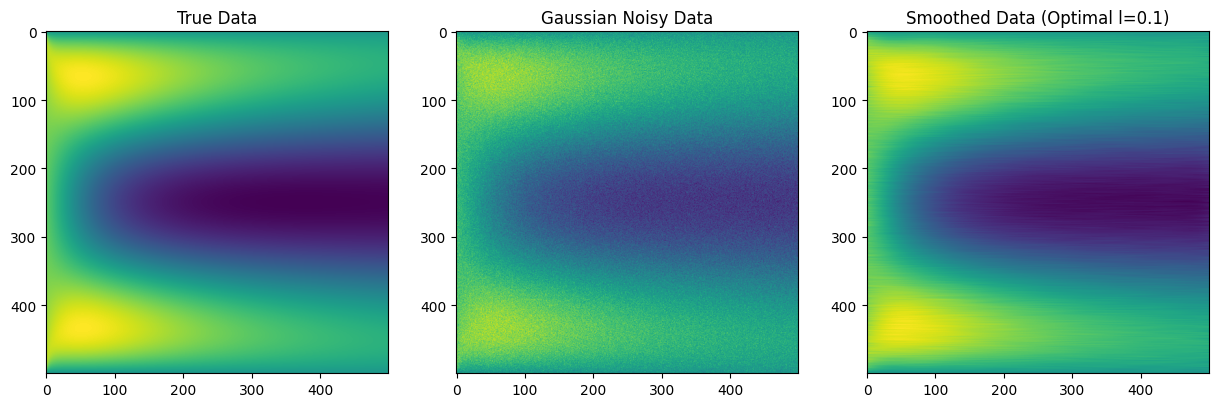

l-value for computing 0.001
MSE with l=0.001: 4.9112832075286825e-05
l-value for computing 0.01
MSE with l=0.01: 4.9112832075286825e-05
l-value for computing 0.1
MSE with l=0.1: 4.9112832075286825e-05
l-value for computing 1
MSE with l=1: 1.7178199953437548e-07
l-value for computing 1.5
MSE with l=1.5: 0.0005374476172075244
l-value for computing 2
MSE with l=2: 0.002765079424335385
Optimal l for evaluating: 1 with MSE: 1.7178199953437548e-07


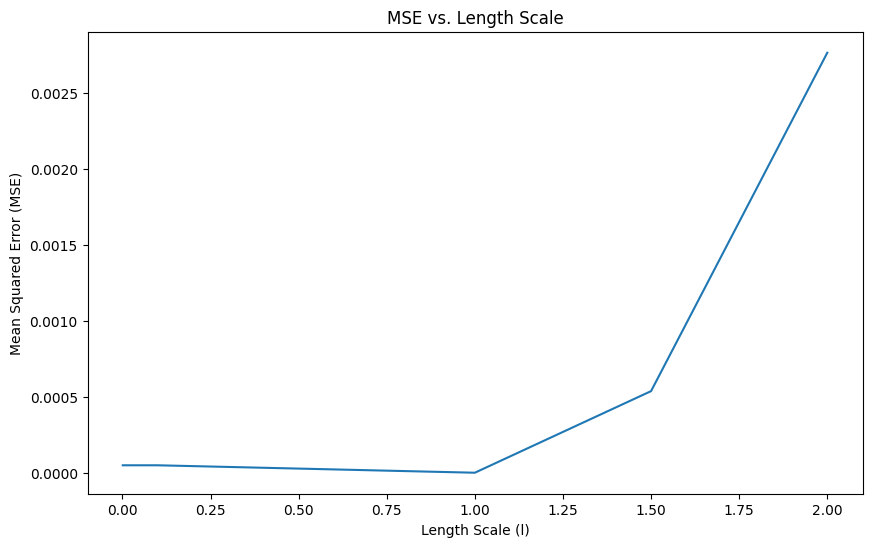

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from derivatives import second_derivative
from diffusion import smooth_rbf_kernel, compute_derivatives_and_evaluate

# a = 0.005
# L = 1
# Nx = 500
# dx = L / (Nx - 1)
# x = np.linspace(0, L, Nx)
# u0 = np.exp((-np.sin(np.pi * x) ** 2))
# t_span = (0, 10)
# t_eval = np.linspace(0, 10, Nx)


# def diffusion(t, u, a, dx):
#     # u[0] = 0
#     # u[-1] = 0
#     uxx = second_derivative(u, dx)
#     ut = a * uxx + a * u ** 2
#     return np.array(ut)

# u_diff = solve_ivp(diffusion, t_span=t_span, y0=u0, args=(a, dx), t_eval=t_eval).y.T
# m, n = u_diff.shape

# u_diff_noisy_normal = u_diff + np.random.normal(scale=0.1, size=(m, n))

import sklearn

a = 0.005
l = .1
L = 1
Nx = 500
dx = L / (Nx - 1)
x = np.linspace(0, L, Nx)
u0 = np.exp((-np.sin(np.pi * x)**2)/2)
t_span = (0, 10)
t_eval = np.linspace(0, 10, 500)

def f(x):
    return np.cos(2 * np.pi * x)

def diffusion(t, u, a, dx):
    u[0] = 0
    u[-1] = 0
    uxx = second_derivative(u, dx)
    ut = a * uxx + a * u**2 + f(x)
    return np.array(ut)
u_diff = []
u_diff.append(solve_ivp(diffusion, t_span=t_span, y0 = u0, args=(a, dx), t_eval=t_eval).y.T)
u_diff = np.squeeze(u_diff)
m, n = u_diff.shape
u_diff = sklearn.preprocessing.normalize(u_diff)
u_diff_noisy_normal = u_diff + np.random.normal(scale=0.01, size=(m, n))

noisy_data = {"normal": u_diff_noisy_normal}

l_values = [0.001, 0.01, 0.1, 1, 1.5, 2]

# cross validation to find optimal l for smoothing
mse_results_cv = {noise_type: [] for noise_type in noisy_data.keys()}
smooth_data_results_cv = {noise_type: [] for noise_type in noisy_data.keys()}

for l in l_values:
    print("l-value for smoothing", l)
    for noise_type, u_diff_train in noisy_data.items():
        mse_train, u_diff_smooth_train, u_rbf = smooth_rbf_kernel(u_diff, u_diff_train, x, l, Nx)
        mse_results_cv[noise_type].append(mse_train)
        smooth_data_results_cv[noise_type].append(u_diff_smooth_train)
        print(f"{noise_type} MSE with l={l} (Train): {mse_train}")
        
optimal_l_rbf = {}
for noise_type, mse_list in mse_results_cv.items():
    min_mse = min(mse_list)
    optimal_l_index = mse_list.index(min_mse)
    optimal_l_value = l_values[optimal_l_index]
    optimal_l_rbf[noise_type] = optimal_l_value
    print(f"Optimal length scale for smoothing: {optimal_l_value} (MSE = {min_mse})")

# smooth with optimal l-value 
mse_u_smooth, u_diff_smooth, u_rbf = smooth_rbf_kernel(u_diff, u_diff_noisy_normal, x, optimal_l_value, Nx)

# plotting 
plt.figure(figsize=(15, 5))
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
axis[0].imshow(u_diff.T)
axis[0].set_title('True Data')
axis[1].imshow(u_diff_noisy_normal.T)
axis[1].set_title('Gaussian Noisy Data')
axis[2].imshow(u_diff_smooth.T)
axis[2].set_title(f'Smoothed Data (Optimal l={optimal_l_value})')
plt.show()

# cross validation to find optimal l for evaluating
mse_results = {noise_type: [] for noise_type in noisy_data.keys()}
smooth_data_results = {noise_type: {} for noise_type in noisy_data.keys()}

for l in l_values:
    print("l-value for computing", l)
    for noise_type, u_diff_noisy in noisy_data.items():
        mse, u_kx, u_kxx = compute_derivatives_and_evaluate(u_diff_smooth, u_rbf, x, l, Nx)
        mse_results[noise_type].append(mse)
        smooth_data_results[noise_type][l] = u_diff_smooth
        print(f"MSE with l={l}: {mse}")

optimal_l = {}
optimal_smooth_data = {}
for noise_type, mses in mse_results.items():
    min_mse = min(mses)
    optimal_l_value_compute = l_values[mses.index(min_mse)]
    optimal_l[noise_type] = optimal_l_value_compute
    optimal_smooth_data[noise_type] = smooth_data_results[noise_type][optimal_l_value_compute]
    print(f"Optimal l for evaluating: {optimal_l_value_compute} with MSE: {min_mse}")
    
plt.figure(figsize=(10, 6))
for noise_type, mses in mse_results.items():
    plt.plot(l_values, mses)
# plt.xscale('log')
plt.xlabel('Length Scale (l)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Length Scale')
plt.show()


d-value for smoothing 2
normal MSE with degree=2: 2.1614100125534508e-05
d-value for smoothing 3
normal MSE with degree=3: 3.243430639801402e-05
d-value for smoothing 4
normal MSE with degree=4: 7.035616521475155e-05
d-value for smoothing 5
normal MSE with degree=5: 0.00017751113528265684
Optimal degree for smoothing: 2 (MSE = 2.1614100125534508e-05)


<Figure size 1500x500 with 0 Axes>

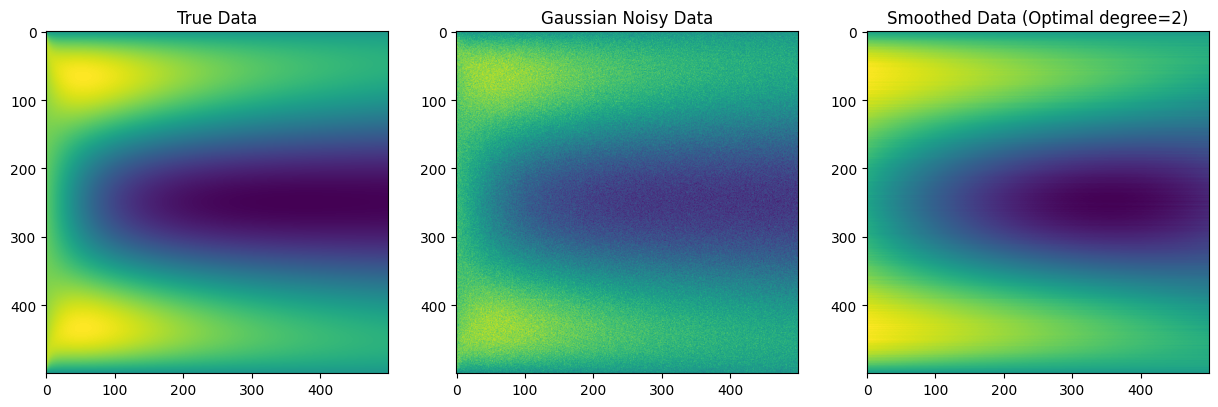

d-value for computing 2
MSE with d=2: 0.010053222925829676
d-value for computing 3
MSE with d=3: 0.0009985421291438888
d-value for computing 4
MSE with d=4: 4.173393211498827e-05
d-value for computing 5
MSE with d=5: 2.442166119955991e-06
Optimal d for evaluating: 5 with MSE: 2.442166119955991e-06


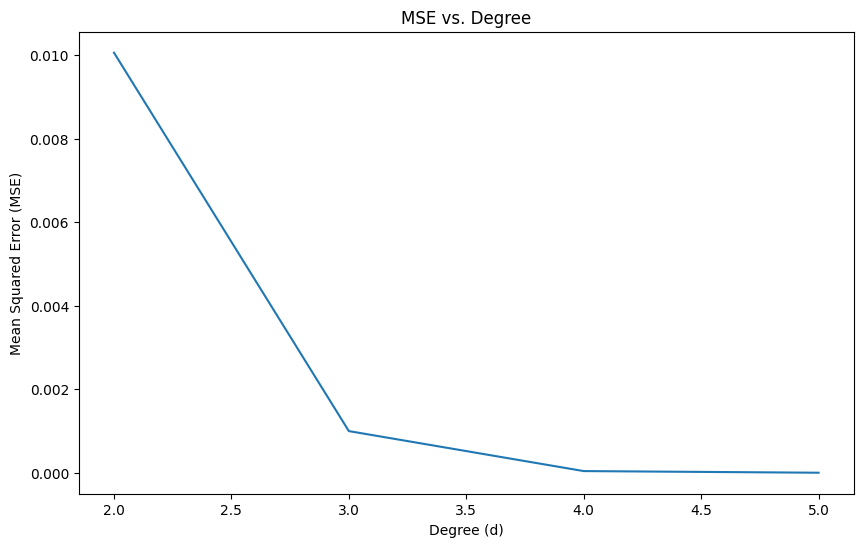

In [2]:
from diffusion import smooth_poly_kernel, compute_derivatives_and_evaluate_poly

deg = [2, 3, 4, 5]
coef =0.23
gam = 1

# cross validation to find optimal l for smoothing
mse_results_poly = {noise_type: [] for noise_type in noisy_data.keys()}
smooth_data_results_poly = {noise_type: [] for noise_type in noisy_data.keys()}

for d in deg:
    print("d-value for smoothing", d)
    for noise_type, u_diff_train in noisy_data.items():
        mse_smooth_poly, u_diff_smooth_train = smooth_poly_kernel(u_diff, u_diff_train, x, deg=d, coef=0.23, gam=1, Nx=500)
        mse_results_poly[noise_type].append(mse_smooth_poly)
        smooth_data_results_poly[noise_type].append(u_diff_smooth_train)
        print(f"{noise_type} MSE with degree={d}: {mse_smooth_poly}")
        
# Finding the optimal degree for each noise type
optimal_d_poly = {}
optimal_smooth_data_poly = {}
for noise_type, mse_list in mse_results_poly.items():
    min_mse = min(mse_list)
    optimal_d_index = mse_list.index(min_mse)
    optimal_d_value = deg[optimal_d_index]
    optimal_d_poly[noise_type] = optimal_d_value
    optimal_smooth_data_poly[noise_type] = smooth_data_results_poly[noise_type][optimal_d_index]
    print(f"Optimal degree for smoothing: {optimal_d_value} (MSE = {min_mse})")
    
# smooth with optimal d-value 
mse_u_smooth_poly, u_diff_smooth_poly= smooth_poly_kernel(u_diff, u_diff_noisy_normal, x, deg=optimal_d_value, coef=0.23, gam=1, Nx=500)

# Plotting the results
for noise_type, u_diff_noisy in noisy_data.items():
    optimal_d_value = optimal_d_poly[noise_type]
    u_diff_smooth = optimal_smooth_data_poly[noise_type]
    
    plt.figure(figsize=(15, 5))
    fig, axis = plt.subplots(1, 3, figsize=(15, 5))
    axis[0].imshow(u_diff.T)
    axis[0].set_title('True Data')
    axis[1].imshow(u_diff_noisy.T)
    axis[1].set_title('Gaussian Noisy Data')
    axis[2].imshow(u_diff_smooth.T)
    axis[2].set_title(f'Smoothed Data (Optimal degree={optimal_d_value})')
    plt.show()
    
# cross validation to find optimal d for evaluating
mse_results_poly = {noise_type: [] for noise_type in noisy_data.keys()}
eval_data_results_poly = {noise_type: {} for noise_type in noisy_data.keys()}

for d in deg:
    print("d-value for computing", d)
    for noise_type, u_diff_noisy in noisy_data.items():
        mse_poly, u_kx, u_kxx = compute_derivatives_and_evaluate_poly(u_diff_smooth_poly, x, deg=d, coef=0.23, gam=1, Nx=500)
        mse_results_poly[noise_type].append(mse_poly)
        eval_data_results_poly[noise_type][d] = u_diff_smooth_poly
        print(f"MSE with d={d}: {mse_poly}")


optimal_d = {}
optimal_evaluate_data = {}
for noise_type, mses in mse_results_poly.items():
    min_mse = min(mses)
    optimal_d_value_compute = deg[mses.index(min_mse)]
    optimal_d[noise_type] = optimal_d_value_compute
    # optimal_evaluate_data[noise_type] = eval_data_results_poly[noise_type][optimal_d_value_compute]
    print(f"Optimal d for evaluating: {optimal_d_value_compute} with MSE: {min_mse}")
    
        
plt.figure(figsize=(10, 6))
for noise_type, mses in mse_results_poly.items():
    plt.plot(deg, mses)
plt.xlabel('Degree (d)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Degree')
plt.show()


In [3]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.integrate import solve_ivp
# from derivatives import second_derivative
# from diffusion import smooth_and_evaluate_rbf, smooth_and_evaluate_poly

# a = 0.005
# L = 1
# Nx = 500
# dx = L / (Nx - 1)
# x = np.linspace(0, L, Nx)
# u0 = np.exp((-np.sin(np.pi * x) ** 2))
# t_span = (0, 10)
# t_eval = np.linspace(0, 10, Nx)


# def diffusion(t, u, a, dx):
#     # u[0] = 0
#     # u[-1] = 0
#     uxx = second_derivative(u, dx)
#     ut = a * uxx + a * u ** 2
#     return np.array(ut)

# u_diff = solve_ivp(diffusion, t_span=t_span, y0=u0, args=(a, dx), t_eval=t_eval).y.T
# m, n = u_diff.shape

# u_diff_noisy_normal = u_diff + np.random.normal(scale=0.1, size=(m, n))

# noisy_data = {"normal": u_diff_noisy_normal}

# l_values = [0.001, 0.01, 0.1, 1, 1.5, 2]
# deg = [2, 3, 4, 5]

# # RBF Kernel smoothing and evaluation
# mse_results = {noise_type: [] for noise_type in noisy_data.keys()}
# smooth_data_results = {noise_type: {} for noise_type in noisy_data.keys()}

# for l in l_values:
#     print(f"Evaluating for length scale l={l}")
#     for noise_type, u_diff_noisy in noisy_data.items():
#         mse, u_diff_smooth = smooth_and_evaluate_rbf(u_diff_noisy, x, l, Nx)
#         mse_results[noise_type].append(mse)
#         smooth_data_results[noise_type][l] = u_diff_smooth
#         print(f"{noise_type} MSE with l={l}: {mse}")

# optimal_l = {}
# optimal_smooth_data = {}
# for noise_type, mses in mse_results.items():
#     min_mse = min(mses)
#     optimal_l_value = l_values[mses.index(min_mse)]
#     optimal_l[noise_type] = optimal_l_value
#     optimal_smooth_data[noise_type] = smooth_data_results[noise_type][optimal_l_value]
#     print(f"Optimal l for {noise_type}: {optimal_l_value} with MSE: {min_mse}")

# plt.figure(figsize=(10, 6))
# for noise_type, mses in mse_results.items():
#     plt.plot(l_values, mses, label=noise_type)
# # plt.xscale('log')
# plt.xlabel('Length Scale (l)')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.title('MSE vs. Length Scale for Different Noise Models')
# # plt.legend()
# plt.show()

# for noise_type, u_diff_noisy in noisy_data.items():
#     optimal_l_value = optimal_l[noise_type]
#     u_diff_smooth = optimal_smooth_data[noise_type]
    
#     plt.figure(figsize=(15, 5))
#     fig, axis = plt.subplots(1, 3, figsize=(15, 5))
#     axis[0].imshow(u_diff.T)
#     axis[0].set_title('True Data')
#     axis[1].imshow(u_diff_noisy.T)
#     axis[1].set_title(f'{noise_type.capitalize()} Noisy Data')
#     axis[2].imshow(u_diff_smooth.T)
#     axis[2].set_title(f'Smoothed Data (Optimal l={optimal_l_value})')
#     plt.show()


# # Polynomial Kernel smoothing and evaluation
# mse_results_poly = {noise_type: [] for noise_type in noisy_data.keys()}
# smooth_data_results_poly = {noise_type: {} for noise_type in noisy_data.keys()}

# for d in deg:
#     print(f"Evaluating for degree={d}")
#     for noise_type, u_diff_noisy in noisy_data.items():
#         mse, u_diff_smooth = smooth_and_evaluate_poly(u_diff_noisy, x, d, 0.23, 1, Nx)
#         mse_results_poly[noise_type].append(mse)
#         smooth_data_results_poly[noise_type][d] = u_diff_smooth
#         print(f"{noise_type} MSE with degree={d}: {mse}")

# optimal_d = {}
# optimal_smooth_data_poly = {}
# for noise_type, mses in mse_results_poly.items():
#     min_mse = min(mses)
#     optimal_d_value = deg[mses.index(min_mse)]
#     optimal_d[noise_type] = optimal_d_value
#     optimal_smooth_data_poly[noise_type] = smooth_data_results_poly[noise_type][optimal_d_value]
#     print(f"Optimal degree for {noise_type}: {optimal_d_value} with MSE: {min_mse}")

# plt.figure(figsize=(10, 6))
# for noise_type, mses in mse_results_poly.items():
#     plt.plot(deg, mses, label=noise_type)
# plt.xlabel('Degree (d)')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.title('MSE vs. Degree for Different Noise Models')
# # plt.legend()
# plt.show()

# for noise_type, u_diff_noisy in noisy_data.items():
#     optimal_d_value = optimal_d[noise_type]
#     u_diff_smooth = optimal_smooth_data_poly[noise_type]
    
#     plt.figure(figsize=(15, 5))
#     fig, axis = plt.subplots(1, 3, figsize=(15, 5))
#     axis[0].imshow(u_diff.T)
#     axis[0].set_title('True Data')
#     axis[1].imshow(u_diff_noisy.T)
#     axis[1].set_title(f'{noise_type.capitalize()} Noisy Data')
#     axis[2].imshow(u_diff_smooth.T)
#     axis[2].set_title(f'Smoothed Data (Optimal degree={optimal_d_value})')
#     plt.show()
